<p align="center">
  <img align="center" width="130" height="80" src="https://upload.wikimedia.org/wikipedia/commons/3/31/Boston_University_wordmark.svg">
</p>

<h5 align="center">MET CS 777 - Big Data Analytics</h5>
<h6 align="center">Fall 2021</h6>

<h2 align="center"> Natural Language Processing with pyspark </h2>
<h2 align="center"> Disaster Tweets classification </h2>

<h3 align="center"> Part 2 </h3>

In [1]:
from utils.plots import *
from utils.prep_ml import *
from utils.prep_rdd import *
from utils.nn_func import *

## Reading the data and create RDD

In [4]:
tweet = pd.read_csv('./nlp-getting-started/train.csv')
tweet= tweet[['id','text','target']]

from pyspark import SparkConf,SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType,StructField, StringType, IntegerType ,ArrayType
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName('tweet').getOrCreate()


#Custom Schema using StructType
mySchema = StructType([ StructField("id", StringType(), True)\
                       ,StructField("text", StringType(), True)\
                       ,StructField("class", StringType(), True)])

sparkDF=spark.createDataFrame(tweet, mySchema) 
small_df = sparkDF.select('id','text','class')
RDD = small_df.rdd
RDD = RDD.map(lambda x: (x[0],x[2],x[1]))
numberOftweets = RDD.count()
keyAndListOfWords =  RDD.map(lambda x : (x[0],x[1],word_tokenizer(x[2]) ))
disaster = keyAndListOfWords.filter(lambda x : x[1] =='1')

## Preprocessing  
* Dictionary of top 1000 words from disaster tweets
* TF_idf
* Split into train and test 

In [7]:
def get_dict(keyAndListOfWords):
    """make a 1000 words dictionary"""
    allWords = keyAndListOfWords.flatMap(lambda x: (x[2])).map(lambda x: (x, 1))
    allCounts = allWords.reduceByKey(lambda x,y: x + y) # I will use lambda instead of add maybe it would be faster in spark 
    topWords = allCounts.top(1000, key= lambda x: x[1])
    topWordsK = sc.parallelize(range(1000))
    dictionary = topWordsK.map(lambda x : (topWords[x][0], x))
    return dictionary

disaster_dictionary = get_dict(disaster)
allDocsWithLabel = get_tfArray(keyAndListOfWords,disaster_dictionary )
tf_idfArray = get_tf_idfArray(allDocsWithLabel, numberOftweets)
training, testing = tf_idfArray.randomSplit([0.8, 0.2], seed=123)

In [ ]:
training.take(1)

## One hot endoding 
labels:   
- 1 -> array([0, 1])
- 0 -> array([1, 0])

In [13]:
step1 = training.map(lambda x: (x[1],x[2])).map(lambda x: (onehotlabel(x[0]), x[1] ))
step1.take(1)[0][0]

array([0, 1])

## Feed forward 
### Output of First layer 
### $  \hat{H} = X w1 + b1$
```python
    def forward(x,w,b):
        return np.dot(x, w) + b
```
### Leaky ReLU 

### $f(x) = 0.01x   for x<0$

### $f(x) = x      for x >= 0$

```python
    def Lrelu(x):
        return np.where(x >= 0, x, x*0.01)
```
### $ H = f{\hat{H}} =  f{(X . w1 + b1)}$

### Output of hidden layer 
### $ \hat{Y}  =  H . w2 + b2$

### Sigmoid

### $ \sigma{(x)} = \frac {1}{1 + e^{-x} } $

```python
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
```

### $  Y  = \sigma{(\hat{Y})}  = \sigma{(f(\hat{H}) w2 + b2)} =  \sigma{( f(X . w1 + b1). w2 + b2)}  $

## Initialization

In [137]:
w1 =np.random.uniform(low = -0.5 , high = 0.5 , size = (1000,128))  
w2 =np.random.uniform(low = -0.5 , high = 0.5 , size = (128,2)) 

# w1 =np.random.normal(0 , 0.5, size = (1000,128))
# w2 =np.random.normal(0 , 0.5, size = (128,2))

b1 =np.random.rand( 1,128)-0.5 
b2 =np.random.rand(1,2)-0.5


## Feed Forward

In [ ]:
step1.map(lambda x: (x[0],x[1],forward(x[1],w1,b1))).\
map(lambda x: (x[0],x[1], x[2], Lrelu(x[2]))).take(1)[0][-1]

In [35]:
fforward = step1.map(lambda x: (x[0],x[1],forward(x[1],w1,b1)))\
        .map(lambda x: (x[0],x[1], x[2], Lrelu(x[2])))\
        .map(lambda x: (x[0],x[1], x[2] ,x[3], forward(x[3],w2,b2)))\
        .map(lambda x: (x[0],x[1], x[2] ,x[3], x[4], sigmoid(x[4])))
fforward.take(1)[0][-1]

array([[0.58179413, 0.6794797 ]])

### Cost Function

### $ SSE =  \frac {1}{2} \sum (\hat{y_i} - y_i)^{2}$

```python
    def cost(y_hat, y):
        return 0.5 * np.sum(np.power(y_hat - y, 2)) 
```

In [39]:
fforward.take(1)[0][0] , fforward.take(1)[0][5]

(array([0, 1]), array([[0.58179413, 0.6794797 ]]))

In [43]:
cost_ = fforward.map(lambda x: (x[0],x[1], x[2] ,x[3], x[4], x[5] ,cost(x[5], x[0])))
cost_.take(1)[0][-1]

0.22060883421358363

### Back propagation 
### $ E =  \frac {1}{2} \sum (\hat{y_i} - y_i)^{2} $



### $ \frac {\partial E}{\partial B_2} = (Y - y) * f^{'}(\hat{Y}) $

```python
    def dEB2(y_pred, y_true, y_h):
        return (y_pred - y_true) * der_sigmoid(y_h)
    
    def der_sigmoid(x):
    sigm = 1 / (1 + np.exp(-x))
    return sigm *(1- sigm)

```

### $ \frac {\partial E}{\partial w_2} = H^{t}. \frac {\partial E}{\partial B_2} $


```python
    def dEW2(h, dB2):
        return np.dot(h.T, dB2)
```

### $ \frac {\partial E}{\partial b_1} = ( \frac {\partial E}{\partial B_2} . w_2^{t} ) * f^{'}(\hat{H}) $

```python
    def dEB1(h_h, dB2, W2):
        return np.dot(dB2, W2.T) * der_Lrelu(h_h)
    
    def der_Lrelu(x):
    return np.where(x >= 0, 1, 0.01)
```

### $ \frac {\partial E}{\partial w_1} = X^{t}. \frac {\partial E}{\partial B_1} $

```python
    def dEW1(x, dB1):
        return np.dot(x.T, dB1)
```

[Refrence](https://medium.com/swlh/mathematics-behind-basic-feed-forward-neural-network-3-layers-python-from-scratch-df88085c8049)

In [45]:
Cost_grad = cost_.map(lambda x: (x[0],x[1], x[2] ,x[3], x[6], dEB2(x[5], x[0] , x[4])))\
        .map(lambda x: (x[1],x[2], x[4], x[5], dEW2(x[3], x[5])))\
        .map(lambda x: (x[0],x[2], x[3], x[4], dEB1(x[1], x[3], w2 )))\
        .map(lambda x: (x[1], x[2],x[3],x[4], dEW1(x[1], x[4] )))\
        .reduce(lambda x,y : (x[0]+y[0],x[1]+y[1],x[2]+y[2],x[3]+y[3],x[4]+y[4] ))

In [48]:
Cost ,DB2,DW2,DB1,DW1 = Cost_grad
n = training.count()
Cost/n

0.3104180375858475

## Optimization 
* Stochastic Gradient Descent (SGD)
* Adam


### Stochastic Gradient Descent (SGD)
### $ w1 = w1 - \alpha \frac {\partial E}{\partial w_1}  $
```python
w1 = w1 - learning_rate * DW1
```
### $ b1 = b1 - \alpha \frac {\partial E}{\partial b_1}  $

```python
b1 = b1 - learning_rate * DB1
```

### $ w2 = w2 - \alpha \frac {\partial E}{\partial w_2}  $

```python
w2 = w2 - learning_rate * DW2
```
### $ b2 = b2 - \alpha \frac {\partial E}{\partial b_2}  $
```python
b2 = b2 - learning_rate * DB2
```


In [69]:
cost_array , w1, b1, w2, b2 = learning(num_iteration = 300 ,\
             data = training ,\
             learning_rate = 0.001 ,\
             optimizer = 'SGD', reg = False )

Iteration No. 0  Cost= 0.306776198561861
Iteration No. 20  Cost= 0.3062189725703716
Iteration No. 40  Cost= 0.3048014352543782
Iteration No. 60  Cost= 0.3011358093522843
Iteration No. 80  Cost= 0.2921947390369777
Iteration No. 100  Cost= 0.27435039921395726
Iteration No. 120  Cost= 0.2567849494194076
Iteration No. 140  Cost= 0.24664828529544794
Iteration No. 160  Cost= 0.22892086547963683
Iteration No. 180  Cost= 0.20377621208753996
Iteration No. 200  Cost= 0.19141437747209986
Iteration No. 220  Cost= 0.1889721161623347
Iteration No. 240  Cost= 0.1880553239369242
Iteration No. 260  Cost= 0.1880050627790661
Iteration No. 280  Cost= 0.18800506619072244


### Cost vs. Iteration

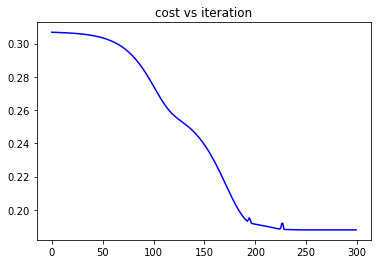

In [70]:
plot_cost(cost_array)

## Prediction

In [71]:
test_pred = testing.map(lambda x: (x[0],int(x[1]),predict(x[2], w1, b1, w2, b2) ))

In [73]:
test_pred.take(10)

[('2608', 1, 1),
 ('2765', 0, 1),
 ('3776', 0, 0),
 ('6048', 1, 1),
 ('9846', 0, 1),
 ('3415', 1, 1),
 ('6881', 1, 1),
 ('6375', 1, 1),
 ('1141', 0, 0),
 ('8311', 1, 1)]

In [77]:
print_result(test_pred)   


============== Results: ==============

Accuracy of model was: %71.72

f1 score of model was: %66.45



In [138]:
w1 =np.random.normal(0 , 0.5, size = (1000,128))
w2 =np.random.normal(0 , 0.5, size = (128,2))

b1 =np.random.rand( 1,128)-0.5 
b2 =np.random.rand(1,2)-0.5

cost_array , w1, b1, w2, b2 = learning(num_iteration = 300 ,\
             data = training ,\
             learning_rate = 0.001 ,\
             optimizer = 'SGD', reg = False )

Iteration No. 0  Cost= 0.3294430147978769
Iteration No. 20  Cost= 0.3289184328993127
Iteration No. 40  Cost= 0.3275728687239728
Iteration No. 60  Cost= 0.32402059967486013
Iteration No. 80  Cost= 0.31478158054027594
Iteration No. 100  Cost= 0.2927526064126302
Iteration No. 120  Cost= 0.2606526162597964
Iteration No. 140  Cost= 0.24788184918559245
Iteration No. 160  Cost= 0.23335265414683115
Iteration No. 180  Cost= 0.21098634406489025
Iteration No. 200  Cost= 0.20892205980718687
Iteration No. 220  Cost= 0.1939377377340866
Iteration No. 240  Cost= 0.19209407149521612
Iteration No. 260  Cost= 0.1909647096881084
Iteration No. 280  Cost= 0.19041035638602274


### Cost vs. Iteration

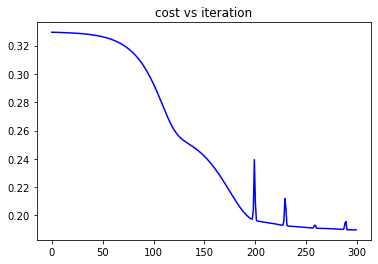

In [140]:
plot_cost(cost_array)

## Prediction

In [139]:
test_pred = testing.map(lambda x: (x[0],int(x[1]),predict(x[2], w1, b1, w2, b2) ))
print_result(test_pred) 


============== Results: ==============

Accuracy of model was: %71.52

f1 score of model was: %65.74



## Adam

The values of Adam depends on :

* $\beta_{1}$ : 1st order exponential decay for first moment estimates = 0.9  
* $\beta_{2}$ : 2nd order exponential decay for second moment estimates = 0.999

On each iteration, we can calculate the moving averages based on these two parameters and gradinat. 

### $m_{t} = \beta_{1}m_{t-1}+(1-\beta_{1})g_{t}$

```python
    # -- Weights --
    m_w = beta1 * m_w + (1 - beta1) *DW
    # -- biases --
    m_b = beta1 * m_b + (1 - beta1) *DB
```

### $\nu_{t} = \beta_{2} \nu_{t-1} + (1-\beta_{2})g^{2}_{t}$

```python
    # -- Weights --   
    v_w = beta2 * v_w + (1 - beta2) * (DW**2)
    # -- biases --
    v_b = beta2 * v_b + (1 - beta2) * (DB)
```

Bias correction of the moving averages 

### $ \hat{m_{t}} =\frac{m_{t}}{1-\beta^{t}_{1}}$

### $ \hat{\nu_{t}} =\frac{\nu_{t}}{1-\beta^{t}_{2}}$

```python
    # -- Weights -- 
    m_w_ = m_w / (1 - beta1**(i + 1))
    v_w_ = v_w / (1 - beta2**(i + 1))
    # -- biases --
    m_b_ = m_b / (1 - beta1**(i + 1))
    v_b_ = v_b / (1 - beta2**(i + 1))
```

Update the parameters (weight and biases) based on the calculated moving averages, step size(learning rate) and a small $\epsilon$ to prevent zero-division

### $w_{t} = w_{t-1} - {\eta} \frac{\hat{m_{t}}}{\sqrt{\hat{\nu_{t}} +\epsilon}}  $
```python
    #Update weights
    w = w - learning_rate * m_w_ / (np.sqrt(abs(v_w_)) + epsilon)
    b = b - learning_rate * m_b_ / (np.sqrt(abs(v_b_)) + epsilon)
```

[Refrence](https://github.com/kiat/BigDataAnalytics/blob/master/Notebooks/Spark-Example-20-Adam-Sgdm-with-Tree-Aggregate.ipynb)

In [89]:
cost_array , w1, b1, w2, b2 = learning(num_iteration = 300 ,\
             data = training ,\
             learning_rate = 0.001 ,\
             optimizer = 'Adam', reg = False )

Iteration No. 0  Cost= 0.3011003714015695
Iteration No. 20  Cost= 0.29720407675192256
Iteration No. 40  Cost= 0.2885260478300003
Iteration No. 60  Cost= 0.2752245826747596
Iteration No. 80  Cost= 0.26369191937510705
Iteration No. 100  Cost= 0.23601876825620105
Iteration No. 120  Cost= 0.20088837855492986
Iteration No. 140  Cost= 0.18841704013035943
Iteration No. 160  Cost= 0.18824465655220085
Iteration No. 180  Cost= 0.1874776440480502
Iteration No. 200  Cost= 0.18684424021219234
Iteration No. 220  Cost= 0.1868533910230233
Iteration No. 240  Cost= 0.1868533910350835
Iteration No. 260  Cost= 0.18685339103508353
Iteration No. 280  Cost= 0.18685339103508353


## Cost vs. Iteration

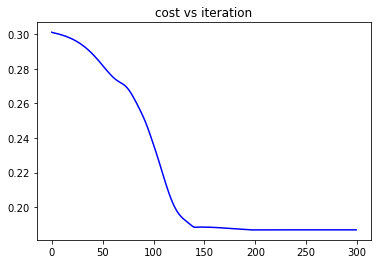

In [93]:
plot_cost(cost_array)

## Prediction

In [91]:
test_pred = testing.map(lambda x: (x[0],int(x[1]),predict(x[2], w1, b1, w2, b2) ))
test_pred.take(10)

[('2608', 1, 1),
 ('2765', 0, 1),
 ('3776', 0, 0),
 ('6048', 1, 1),
 ('9846', 0, 1),
 ('3415', 1, 1),
 ('6881', 1, 1),
 ('6375', 1, 1),
 ('1141', 0, 0),
 ('8311', 1, 1)]

In [92]:
print_result(test_pred) 


============== Results: ==============

Accuracy of model was: %71.18

f1 score of model was: %65.47



## More tests 

In [116]:
SGD_cost_array , w1, b1, w2, b2 = learning(num_iteration = 300 ,\
             data = training ,\
             learning_rate = 0.12 ,\
             optimizer = 'SGD', reg = False )

Iteration No. 0  Cost= 0.26919794722666074
Iteration No. 20  Cost= 0.264050415206717
Iteration No. 40  Cost= 0.25437843711129654
Iteration No. 60  Cost= 0.23428633360542808
Iteration No. 80  Cost= 0.20465764354894028
Iteration No. 100  Cost= 0.191138482497972
Iteration No. 120  Cost= 0.1885741623738658
Iteration No. 140  Cost= 0.1873831345860074
Iteration No. 160  Cost= 0.18686277893348907
Iteration No. 180  Cost= 0.18683579345499593
Iteration No. 200  Cost= 0.18683257758987495
Iteration No. 220  Cost= 0.1867874385842726
Iteration No. 240  Cost= 0.18668799557245838
Iteration No. 260  Cost= 0.18662625168995264
Iteration No. 280  Cost= 0.1866272340947867


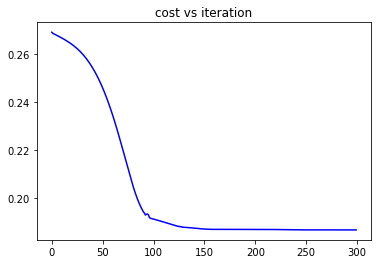

In [117]:
plot_cost(SGD_cost_array)

In [118]:
test_pred = testing.map(lambda x: (x[0],int(x[1]),predict(x[2], w1, b1, w2, b2) ))
test_pred.take(10), print_result(test_pred)   


============== Results: ==============

Accuracy of model was: %71.31

f1 score of model was: %65.97



([('2608', 1, 1),
  ('2765', 0, 1),
  ('3776', 0, 0),
  ('6048', 1, 1),
  ('9846', 0, 0),
  ('3415', 1, 1),
  ('6881', 1, 1),
  ('6375', 1, 1),
  ('1141', 0, 0),
  ('8311', 1, 1)],
 None)

In [132]:
ADAM_cost_array , w1, b1, w2, b2 = learning(num_iteration = 300 ,\
             data = training ,\
             learning_rate = 0.001 ,\
             optimizer = 'Adam', reg = False )

Iteration No. 0  Cost= 0.3466485344991545
Iteration No. 20  Cost= 0.2917385757174131
Iteration No. 40  Cost= 0.2809644343781877
Iteration No. 60  Cost= 0.2794629492722659
Iteration No. 80  Cost= 0.27470527751956025
Iteration No. 100  Cost= 0.26417563003874245
Iteration No. 120  Cost= 0.2396571046446404
Iteration No. 140  Cost= 0.2057449115048158
Iteration No. 160  Cost= 0.195472312388166
Iteration No. 180  Cost= 0.19389520289520132
Iteration No. 200  Cost= 0.1933813334713627
Iteration No. 220  Cost= 0.1933815527019204
Iteration No. 240  Cost= 0.19338144655300304
Iteration No. 260  Cost= 0.1933811401959375
Iteration No. 280  Cost= 0.19338032963507665


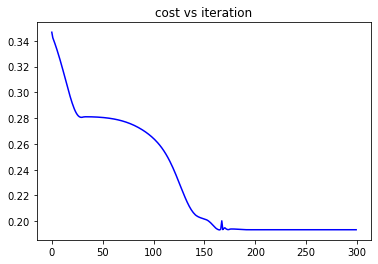

In [133]:
plot_cost(ADAM_cost_array)

In [134]:
test_pred = testing.map(lambda x: (x[0],int(x[1]),predict(x[2], w1, b1, w2, b2) ))
test_pred.take(10), print_result(test_pred)  


============== Results: ==============

Accuracy of model was: %71.45

f1 score of model was: %66.07



([('2608', 1, 1),
  ('2765', 0, 1),
  ('3776', 0, 0),
  ('6048', 1, 1),
  ('9846', 0, 1),
  ('3415', 1, 1),
  ('6881', 1, 1),
  ('6375', 1, 1),
  ('1141', 0, 0),
  ('8311', 1, 0)],
 None)

## Cost Comparison with SGD and Adam Optimizers

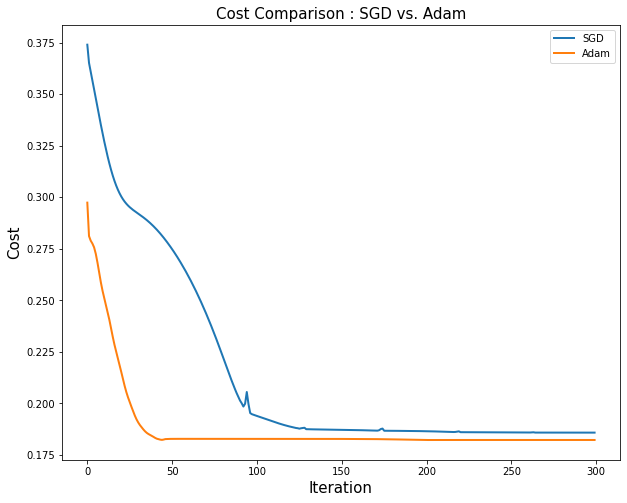

In [115]:
plot_cost_SGD_Adam( SGD_cost_array , ADAM_cost_array  , name='plot.png')

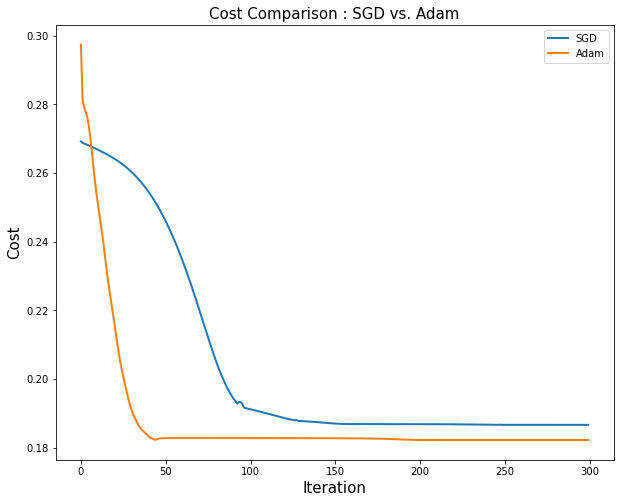

In [119]:
plot_cost_SGD_Adam( SGD_cost_array , ADAM_cost_array  , name='plot.png')

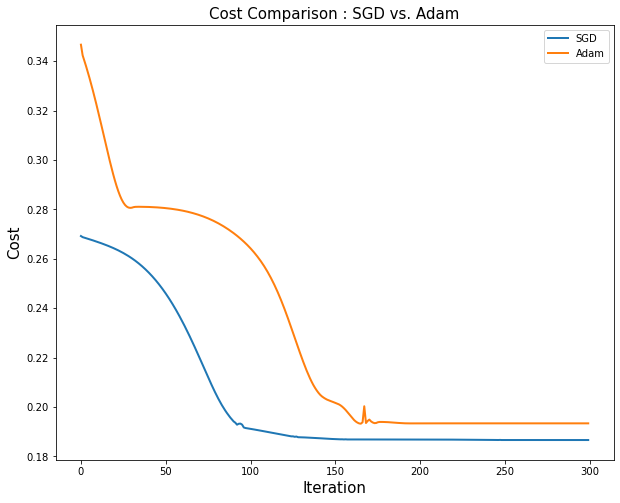

In [136]:
plot_cost_SGD_Adam( SGD_cost_array , ADAM_cost_array  , name='./images/plotSGD_ADAm.png')

In [ ]:
!python RDD_NN.py './nlp-getting-started/train.csv' './out/NN_rdd'

============== Results: ==============

Accuracy of model was: %71.10

f1 score of model was: %66.56